In [1]:
import numpy as np

In [5]:
def _whctrs(anchor):
    """
    Return width, height, x center, and y center for an anchor (window).
    """

    w = anchor[2] - anchor[0] + 1
    h = anchor[3] - anchor[1] + 1
    x_ctr = anchor[0] + 0.5 * (w - 1)
    y_ctr = anchor[1] + 0.5 * (h - 1)
    return w, h, x_ctr, y_ctr

In [12]:
def _mkanchors(ws, hs, x_ctr, y_ctr):
    """
    Given a vector of widths (ws) and heights (hs) around a center
    (x_ctr, y_ctr), output a set of anchors (windows).
    """

    ws = ws[:, np.newaxis]
    hs = hs[:, np.newaxis]
    anchors = np.hstack((x_ctr - 0.5 * (ws - 1),
                         y_ctr - 0.5 * (hs - 1),
                         x_ctr + 0.5 * (ws - 1),
                         y_ctr + 0.5 * (hs - 1)))
    return anchors

In [15]:
def _ratio_enum(anchor, ratios):
    """
    Enumerate a set of anchors for each aspect ratio wrt an anchor.
    """

    w, h, x_ctr, y_ctr = _whctrs(anchor)
    size = w * h
    size_ratios = size / ratios
    ws = np.round(np.sqrt(size_ratios))
    hs = np.round(ws * ratios)
    anchors = _mkanchors(ws, hs, x_ctr, y_ctr)
    return anchors

In [16]:
def _ratio_enum(anchor, ratios):
    """
    Enumerate a set of anchors for each aspect ratio wrt an anchor.
    """

    w, h, x_ctr, y_ctr = _whctrs(anchor)
    size = w * h
    size_ratios = size / ratios
    ws = np.round(np.sqrt(size_ratios))
    hs = np.round(ws * ratios)
    anchors = _mkanchors(ws, hs, x_ctr, y_ctr)
    return anchors

In [25]:
def _scale_enum(anchor, scales):
    """
    Enumerate a set of anchors for each scale wrt an anchor.
    """

    w, h, x_ctr, y_ctr = _whctrs(anchor)
    ws = w * scales
    hs = h * scales
    anchors = _mkanchors(ws, hs, x_ctr, y_ctr)
    return anchors

In [124]:
def generate_anchors(base_size=16, ratios=[0.5, 1, 2],
                     scales=2**np.arange(3, 6)):
    """
    Generate anchor (reference) windows by enumerating aspect ratios X
    scales wrt a reference (0, 0, 15, 15) window.
    """

    base_anchor = np.array([1, 1, base_size, base_size]) - 1
    ratio_anchors = _ratio_enum(base_anchor, ratios)
    anchors = np.vstack([_scale_enum(ratio_anchors[i, :], scales)
                         for i in np.arange(ratio_anchors.shape[0])])
    return anchors

In [125]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

(-1.0, 0.5) 6.0 3.0
(-4.0, -1.0) 12.0 6.0
(0.5, 1.25) 3.0 1.5
(0.0, 0.0) 4.0 4.0
(-2.0, -2.0) 8.0 8.0
(1.0, 1.0) 2.0 2.0
(0.5, -1.0) 3.0 6.0
(-1.0, -4.0) 6.0 12.0
(1.25, 0.5) 1.5 3.0


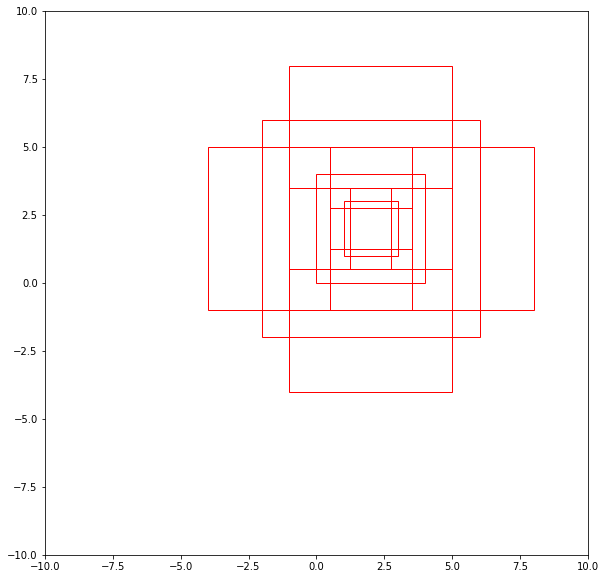

In [247]:
fig = plt.figure(figsize=(10,10))
img = np.ones((128,18, 3))
plt.imshow(img)
axes = plt.gca()
plt.xlim([-10,10])
plt.ylim([-10,10])
anchors = generate_anchors(base_size=4, ratios=np.array([0.5, 1, 2]), scales=np.array([1, 2, 0.5]))
for i in range(anchors.shape[0]):
    box = anchors[i]
    print((box[0], box[1]), box[2] - box[0] + 1, box[3] - box[1] + 1)
    patch = patches.Rectangle((box[0], box[1]), box[2] - box[0] + 1, box[3] - box[1] + 1, edgecolor='r', facecolor='none')
    axes.add_patch(patch)

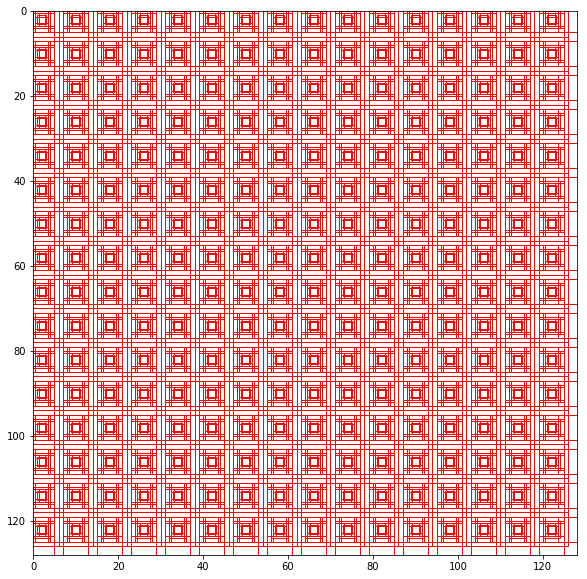

In [251]:
size_X = 16
size_Y = 16
rpn_stride = 8
base_anchors = generate_anchors(base_size=4, ratios=np.array([0.5, 1, 2]), scales=np.array([1, 2, 0.5]))
shift_x = np.arange(size_X) * rpn_stride
shift_y = np.arange(size_Y) * rpn_stride
shift_x, shift_y = np.meshgrid(shift_x, shift_y)
shifts = np.vstack((shift_x.ravel(), shift_y.ravel(),
                    shift_x.ravel(), shift_y.ravel())).transpose()
anchors_num = base_anchors.shape[0]
A = anchors_num
K = shifts.shape[0]
all_anchors = (base_anchors.reshape((1, A, 4)) +
               shifts.reshape((1, K, 4)).transpose((1, 0, 2)))
all_anchors = all_anchors.reshape((K * A, 4))

img = np.ones((128, 128, 3))
plt.figure(figsize=(10,10))
plt.imshow(img, extent=(0, 128, 128, 0))
axs = plt.gca()  
for i in range(0, all_anchors.shape[0]):
    box = all_anchors[i]
    rec = patches.Rectangle((box[0], box[1]), box[2] - box[0] + 1, box[3] - box[1] + 1, edgecolor='r', facecolor='none')
    axs.add_patch(rec)

plt.show()

### second approach

In [233]:
size_Y = 16 #feat map size
size_X = 16
rpn_stride = 8 # downsample size
scales = [2,4,8]
ratios = [0.5, 1, 2]
def anchor_gen(size_X, size_Y, rpn_stride, scales, ratios):
    scales, ratios = np.meshgrid(scales, ratios)
    scales, ratios = scales.flatten(), ratios.flatten()
    scalesY = scales * np.sqrt(ratios)
    scalesX = scales / np.sqrt(ratios)
    
    shiftX = np.arange(0, size_X) * rpn_stride
    shiftY = np.arange(0, size_Y) * rpn_stride
    shiftX, shiftY = np.meshgrid(shiftX, shiftY)
    print(shiftX.shape)
    centerX, anchorX = np.meshgrid(shiftX, scalesX)
    centerY, anchorY = np.meshgrid(shiftY, scalesY)
    print(centerY.shape) # (9, 256)
    print(anchorX.shape)
    anchor_center = np.stack([centerY, centerX], axis=2).reshape(-1,2)
    anchor_size = np.stack([anchorY, anchorX],axis=2).reshape(-1,2)
    print(anchor_size.shape)
    boxes = np.concatenate([anchor_center-0.5*anchor_size, anchor_center+0.5*anchor_size], axis=1)
    return boxes

(16, 16)
(9, 256)
(9, 256)
(2304, 2)


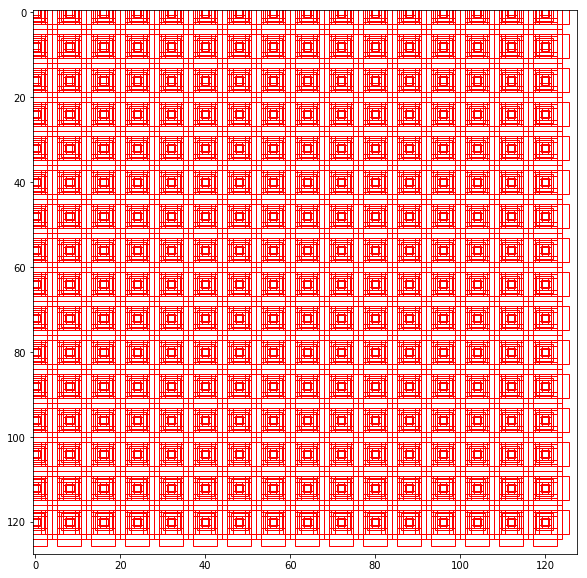

In [249]:
plt.figure(figsize=(10,10))
img = np.ones((128,128, 3))
fig = plt.imshow(img)
axes = plt.gca()
anchors = anchor_gen(size_X, size_Y, rpn_stride, scales, ratios)
for i in range(anchors.shape[0]): 
    box = anchors[i]
    patch = axes.add_patch(patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], edgecolor='r', facecolor='none'))